# Проект поиска профитной торговой стратегии на криптобирже

## Задача

* **Проанализировать 3 самые популярные торговые метрики по мнению Тинькофф инвестиций (https://www.tbank.ru/invest/help/educate/trading/) и влияние их сигналов на вероятность извлечения дохода из позиции**
* **По возможности обучить модель, которую можно будет применить для торговли**

## План работы

* **Загрузить данные** Это будут историчейские данные по ценам SOL загруженные с биржы Bybit за несколько месяцев (https://www.bybit.com/derivatives/en/history-data)
* **Проверка данных на корректность загрузки**
* **Предобработка данных**
* **Исследовательский анализ**
* **Подготовка данных для ML**
* **Обучение моделей**
* **Анализ результатов моделей**
* **Вывод**

### Импорты

In [8]:
import pandas as pd
import sklearn
import talib
import torch
import matplotlib.pyplot as plt
import seaborn as sn
import shap
import numpy as np
import phik

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    RobustScaler,
    OneHotEncoder,
    OrdinalEncoder
)

from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import lightgbm as lgb

from sklearn.metrics import mean_absolute_error, mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

In [9]:
RANDOM_STATE = 42

In [10]:
pd.options.display.max_columns = 100

## Загрузка данных

In [12]:
col_names = ['date_time','open_price','high_price','low_price','close_price','trade_volume']

In [13]:
date_col = ['date_time']

In [14]:
sol_data_01 = pd.read_csv("H:\SOLUSDT_5_2024-01-01_2024-01-31.csv", names=col_names, parse_dates=date_col)

In [15]:
sol_data_02 = pd.read_csv("H:\SOLUSDT_5_2024-02-01_2024-02-29.csv", names=col_names, parse_dates=date_col)

In [16]:
sol_data_03 = pd.read_csv("H:\SOLUSDT_5_2024-03-01_2024-03-31.csv", names=col_names, parse_dates=date_col)

In [17]:
sol_data_04 = pd.read_csv("H:\SOLUSDT_5_2024-04-01_2024-04-30.csv", names=col_names, parse_dates=date_col)

In [18]:
sol_data_05 = pd.read_csv("H:\SOLUSDT_5_2024-05-01_2024-05-31.csv", names=col_names, parse_dates=date_col)

In [19]:
sol_data_06 = pd.read_csv("H:\SOLUSDT_5_2024-06-01_2024-06-30.csv", names=col_names, parse_dates=date_col)

In [20]:
sol_data_07 = pd.read_csv("H:\SOLUSDT_5_2024-07-01_2024-07-31.csv", names=col_names, parse_dates=date_col)

## Проверка загруженных данных

### Sol_data_01

In [23]:
sol_data_01.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-01-01 00:00:00,104.967,105.072,104.610,104.699,13397.4
1,2024-01-01 00:05:00,104.699,104.900,104.636,104.707,8440.9
2,2024-01-01 00:10:00,104.707,104.795,104.610,104.770,3426.5
3,2024-01-01 00:15:00,104.770,105.270,104.769,105.105,20284.9
4,2024-01-01 00:20:00,105.105,105.147,104.713,104.859,9132.7


In [24]:
sol_data_01.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     600 non-null    datetime64[ns]
 1   open_price    600 non-null    float64       
 2   high_price    600 non-null    float64       
 3   low_price     600 non-null    float64       
 4   close_price   600 non-null    float64       
 5   trade_volume  600 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 28.3 KB


In [25]:
sol_data_01.shape

(600, 6)

### Sol_data_02

In [27]:
sol_data_02.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-02-01 00:00:00,97.972,98.337,97.741,98.154,78913.8
1,2024-02-01 00:05:00,98.154,98.358,97.931,98.230,49701.0
2,2024-02-01 00:10:00,98.230,98.441,98.018,98.208,48445.5
3,2024-02-01 00:15:00,98.208,98.703,98.208,98.539,63167.8
4,2024-02-01 00:20:00,98.539,98.583,96.753,96.942,202825.0


In [28]:
sol_data_02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     8353 non-null   datetime64[ns]
 1   open_price    8353 non-null   float64       
 2   high_price    8353 non-null   float64       
 3   low_price     8353 non-null   float64       
 4   close_price   8353 non-null   float64       
 5   trade_volume  8353 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 391.7 KB


In [29]:
sol_data_02.shape

(8353, 6)

### Sol_data_03

In [31]:
sol_data_03.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-03-01 00:00:00,130.655,130.696,129.563,129.785,82267.6
1,2024-03-01 00:05:00,129.785,129.923,127.866,128.019,151424.8
2,2024-03-01 00:10:00,128.019,129.190,127.548,128.807,115069.5
3,2024-03-01 00:15:00,128.807,128.823,128.150,128.378,56665.1
4,2024-03-01 00:20:00,128.378,128.675,126.200,126.618,135527.5


In [32]:
sol_data_03.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8929 entries, 0 to 8928
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     8929 non-null   datetime64[ns]
 1   open_price    8929 non-null   float64       
 2   high_price    8929 non-null   float64       
 3   low_price     8929 non-null   float64       
 4   close_price   8929 non-null   float64       
 5   trade_volume  8929 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 418.7 KB


In [33]:
sol_data_03.shape

(8929, 6)

### Sol_data_04

In [35]:
sol_data_04.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-04-01 00:00:00,199.650,199.733,199.427,199.591,9009.1
1,2024-04-01 00:05:00,199.591,199.704,199.249,199.590,13162.2
2,2024-04-01 00:10:00,199.590,199.877,199.352,199.358,17536.0
3,2024-04-01 00:15:00,199.358,199.400,199.008,199.021,10926.9
4,2024-04-01 00:20:00,199.021,199.327,198.703,198.970,17711.8


In [36]:
sol_data_04.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8641 entries, 0 to 8640
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     8641 non-null   datetime64[ns]
 1   open_price    8641 non-null   float64       
 2   high_price    8641 non-null   float64       
 3   low_price     8641 non-null   float64       
 4   close_price   8641 non-null   float64       
 5   trade_volume  8641 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 405.2 KB


In [37]:
sol_data_04.shape

(8641, 6)

### Sol_data_05

In [39]:
sol_data_05.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-05-01 00:00:00,124.83,125.77,124.80,125.56,36685.3
1,2024-05-01 00:05:00,125.56,125.78,125.38,125.66,37645.9
2,2024-05-01 00:10:00,125.66,125.83,125.33,125.49,23338.6
3,2024-05-01 00:15:00,125.49,125.82,125.16,125.58,18435.7
4,2024-05-01 00:20:00,125.58,125.68,125.03,125.22,13761.7


In [40]:
sol_data_05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8929 entries, 0 to 8928
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     8929 non-null   datetime64[ns]
 1   open_price    8929 non-null   float64       
 2   high_price    8929 non-null   float64       
 3   low_price     8929 non-null   float64       
 4   close_price   8929 non-null   float64       
 5   trade_volume  8929 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 418.7 KB


In [41]:
sol_data_05.shape

(8929, 6)

### Sol_data_06

In [43]:
sol_data_06.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-06-01 00:00:00,166.72,166.87,166.59,166.67,6085.2
1,2024-06-01 00:05:00,166.67,166.74,166.53,166.68,7843.9
2,2024-06-01 00:10:00,166.68,166.98,166.67,166.92,4688.6
3,2024-06-01 00:15:00,166.92,167.19,166.66,167.11,13173.5
4,2024-06-01 00:20:00,167.11,167.17,166.76,166.77,7087.7


In [44]:
sol_data_06.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8641 entries, 0 to 8640
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     8641 non-null   datetime64[ns]
 1   open_price    8641 non-null   float64       
 2   high_price    8641 non-null   float64       
 3   low_price     8641 non-null   float64       
 4   close_price   8641 non-null   float64       
 5   trade_volume  8641 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 405.2 KB


In [45]:
sol_data_06.shape

(8641, 6)

### Sol_data_07

In [47]:
sol_data_07.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume
0,2024-07-01 00:00:00,144.29,144.58,143.97,144.10,39948.2
1,2024-07-01 00:05:00,144.10,144.31,144.05,144.21,9858.4
2,2024-07-01 00:10:00,144.21,144.28,144.04,144.23,21809.2
3,2024-07-01 00:15:00,144.23,144.53,143.77,144.15,61639.2
4,2024-07-01 00:20:00,144.15,144.63,144.03,144.39,17151.3


In [48]:
sol_data_07.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6102 entries, 0 to 6101
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date_time     6102 non-null   datetime64[ns]
 1   open_price    6102 non-null   float64       
 2   high_price    6102 non-null   float64       
 3   low_price     6102 non-null   float64       
 4   close_price   6102 non-null   float64       
 5   trade_volume  6102 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 286.2 KB


In [49]:
sol_data_07.shape

(6102, 6)

## Обьединяем датасеты

In [51]:
sol_data = pd.concat([sol_data_01, sol_data_02, sol_data_03, sol_data_04, sol_data_05, sol_data_06, sol_data_07], axis=0)

После обьединения дублируются головы и хвосты соседних датасетов

In [53]:
sol_data.duplicated().sum()

5

In [54]:
sol_data = sol_data.drop_duplicates()

## Предобработка данных

**Добавляем target как движение цены вверх-вниз от текущего значения**

* **1 - вверх**
* **0 - вниз**

In [57]:
def target_maker(row, char):
    if char == 'c':
        if row['next_close_price'] > row['close_price']:
            return(1)
        else:
            return(0)
    if char == 'h':
        if row['next_high_price'] > row['close_price']:
            return(1)
        else:
            return(0)

In [58]:
sol_data['next_close_price'] = sol_data['close_price'].shift(-1)

In [59]:
sol_data['next_high_price'] = sol_data['high_price'].shift(-1)

In [60]:
sol_data['target'] = sol_data.apply(lambda row: target_maker(row, 'c'), axis=1)

In [61]:
sol_data.head()

,date_time,open_price,high_price,low_price,close_price,trade_volume,next_close_price,next_high_price,target
0,2024-01-01 00:00:00,104.967,105.072,104.610,104.699,13397.4,104.707,104.900,1
1,2024-01-01 00:05:00,104.699,104.900,104.636,104.707,8440.9,104.770,104.795,1
2,2024-01-01 00:10:00,104.707,104.795,104.610,104.770,3426.5,105.105,105.270,1
3,2024-01-01 00:15:00,104.770,105.270,104.769,105.105,20284.9,104.859,105.147,0
4,2024-01-01 00:20:00,105.105,105.147,104.713,104.859,9132.7,104.697,104.880,0


In [62]:
sol_data['target'].value_counts()

target
0    25131
1    25059
Name: count, dtype: int64

**Дисбаланса признаков нет))**

In [64]:
sol_data.isna().sum()

date_time           0
open_price          0
high_price          0
low_price           0
close_price         0
trade_volume        0
next_close_price    1
next_high_price     1
target              0
dtype: int64

**Появился прпоуск в последней строке в столбце 'next_close_price', т.к в эту строку неоткуда было шифтить-1 данные**

Удалим последнюю строку для чистоты датасета

In [67]:
sol_data = sol_data.drop(sol_data.index[-1])

In [68]:
sol_data = sol_data.set_index('date_time')

## Добавление признаков

**Добавляем метрики ЕМА**

Возможно EMA как абсолютная метрика будет мешать универсальности модели, так как при обучении ЕМА может быть в райне 150, при боковике, а в работе цена SOL может быть 200-300-400 юзд и следовательно текущая ЕМА будет сильно отличаться от обучающей. Возможно будет более целесообразно внести такой признак как delta текущей цены от EMA и следовательно модель будет учитывать не абсолютное значение ЕМА и цены, а факт пересечения цены скользящей и ее удаленность от скользящей снизу или сверху

In [72]:
sol_data['ema_50'] = talib.EMA(sol_data['close_price'], timeperiod=50)

In [73]:
sol_data['ema_100'] = talib.EMA(sol_data['close_price'], timeperiod=100)

In [74]:
sol_data['ema_200'] = talib.EMA(sol_data['close_price'], timeperiod=200)

**Добавим такие признаки как отклонение текущей цены (цены открытия) от разных EMA**

In [76]:
def delta_ema_50(row):
    delta = row['close_price'] - row['ema_50']
    return delta

In [77]:
def delta_ema_100(row):
    delta = row['close_price'] - row['ema_100']
    return delta

In [78]:
def delta_ema_200(row):
    delta = row['close_price'] - row['ema_200']
    return delta

In [79]:
sol_data['delta_ema_50'] = sol_data.apply(lambda row: delta_ema_50(row), axis=1)

In [80]:
sol_data['delta_ema_100'] = sol_data.apply(lambda row: delta_ema_100(row), axis=1)

In [81]:
sol_data['delta_ema_200'] = sol_data.apply(lambda row: delta_ema_200(row), axis=1)

**Добавляем RSI**

In [83]:
sol_data['rsi'] = talib.RSI(sol_data['close_price'], timeperiod=14)

**Добавляем MACD**

In [85]:
sol_data['macd_line'], sol_data['signal_line'], sol_data['macd_hist'] = talib.MACD(sol_data['close_price'], fastperiod=8, slowperiod=17, signalperiod=9)

**Добавляем стохастик**

In [87]:
sol_data['stoch_k'], sol_data['stoch_d'] = talib.STOCH(high=sol_data['high_price'], low=sol_data['low_price'], close=sol_data['close_price'], fastk_period=14, slowk_period=1, slowk_matype=0, slowd_period=3, slowd_matype=0)

In [88]:
sol_data.head()

,open_price,high_price,low_price,close_price,trade_volume,next_close_price,next_high_price,target,ema_50,ema_100,ema_200,delta_ema_50,delta_ema_100,delta_ema_200,rsi,macd_line,signal_line,macd_hist,stoch_k,stoch_d
date_time,,,,,,,,,,,,,,,,,,,,
2024-01-01 00:00:00,104.967,105.072,104.610,104.699,13397.4,104.707,104.900,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 00:05:00,104.699,104.900,104.636,104.707,8440.9,104.770,104.795,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 00:10:00,104.707,104.795,104.610,104.770,3426.5,105.105,105.270,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 00:15:00,104.770,105.270,104.769,105.105,20284.9,104.859,105.147,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-01-01 00:20:00,105.105,105.147,104.713,104.859,9132.7,104.697,104.880,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Мы видим много пропусков, которые связаны с тем, что для многих метрик теханализа необходима сборная информация по окну определенного размера, и следовательно они не могут предоставить инфу до закрытия первого окна**

In [90]:
sol_data.isna().sum()

open_price            0
high_price            0
low_price             0
close_price           0
trade_volume          0
next_close_price      0
next_high_price       0
target                0
ema_50               49
ema_100              99
ema_200             199
delta_ema_50         49
delta_ema_100        99
delta_ema_200       199
rsi                  14
macd_line            24
signal_line          24
macd_hist            24
stoch_k              15
stoch_d              15
dtype: int64

**Видим, что как и было очевидно больше всего пропусков в столбцах связанных с EMA_200. Удалим первые 200 строк датасета, чтобы убрать пропущенные данные**

In [92]:
sol_data = sol_data.drop(sol_data.index[:199])

In [93]:
sol_data.isna().sum()

open_price          0
high_price          0
low_price           0
close_price         0
trade_volume        0
next_close_price    0
next_high_price     0
target              0
ema_50              0
ema_100             0
ema_200             0
delta_ema_50        0
delta_ema_100       0
delta_ema_200       0
rsi                 0
macd_line           0
signal_line         0
macd_hist           0
stoch_k             0
stoch_d             0
dtype: int64

**Пропусков больше нет**

## Анализ данных для создания торговой стратегии

**Также добавим признаки не с абсолютными значениями метрик теханализа, а с фактом наступления значительных событий, которые мониторятся метриками теханализа.**

**Таких как:**
* Пересечение RSI уровня перекупленности или перепроданности
* Пересечение сигнальной линии MACD снизу или сверху
* Пересечение медленной и быстрой линии стохастика

In [97]:
sol_data.head()

,open_price,high_price,low_price,close_price,trade_volume,next_close_price,next_high_price,target,ema_50,ema_100,ema_200,delta_ema_50,delta_ema_100,delta_ema_200,rsi,macd_line,signal_line,macd_hist,stoch_k,stoch_d
date_time,,,,,,,,,,,,,,,,,,,,
2024-01-01 16:35:00,105.924,105.941,105.382,105.466,20102.4,105.806,105.859,1,104.525660,103.956305,103.248935,0.940340,1.509695,2.217065,57.250350,0.261742,0.239885,0.021857,59.250474,70.192916
2024-01-01 16:40:00,105.466,105.859,105.350,105.806,10822.2,105.724,105.833,0,104.575869,103.992933,103.274378,1.230131,1.813067,2.531622,61.038870,0.271645,0.246237,0.025408,75.379507,71.869070
2024-01-01 16:45:00,105.806,105.833,105.619,105.724,13272.1,105.732,105.759,1,104.620894,104.027212,103.298753,1.103106,1.696788,2.425247,59.665524,0.262673,0.249524,0.013149,67.247956,67.292646
2024-01-01 16:50:00,105.724,105.759,105.517,105.732,8156.6,105.445,105.795,0,104.664467,104.060970,103.322964,1.067533,1.671030,2.409036,59.760647,0.250873,0.249794,0.001079,67.683924,70.103796
2024-01-01 16:55:00,105.732,105.795,105.445,105.445,11218.1,104.756,105.482,0,104.695076,104.088376,103.344079,0.749924,1.356624,2.100921,54.770300,0.204632,0.240762,-0.036129,52.043597,62.325159


### Уровни RSI

**Добавим категоральный признак уровня RSI**

* Перекупленность (RSI > 70)
* Нормальный уровень 30 < RSI < 70
* Перепроданность RSI < 30

In [100]:
def rsi_lvl(data):
    if data >= 0 and data <= 15:
        return('перепроданность_15')
    if  data > 15 and data <= 30:
        return('перепроданнсть_30')
    if  data >=70 and data < 85:
        return('перекупленность_70')
    if  data >= 85 and data <= 100:
        return('перекупленность_85')
    else:
        return('средние значения')

In [101]:
sol_data['rsi_lvl'] = sol_data['rsi'].apply(rsi_lvl)

In [102]:
sol_data.head()

,open_price,high_price,low_price,close_price,trade_volume,next_close_price,next_high_price,target,ema_50,ema_100,ema_200,delta_ema_50,delta_ema_100,delta_ema_200,rsi,macd_line,signal_line,macd_hist,stoch_k,stoch_d,rsi_lvl
date_time,,,,,,,,,,,,,,,,,,,,,
2024-01-01 16:35:00,105.924,105.941,105.382,105.466,20102.4,105.806,105.859,1,104.525660,103.956305,103.248935,0.940340,1.509695,2.217065,57.250350,0.261742,0.239885,0.021857,59.250474,70.192916,средние значения
2024-01-01 16:40:00,105.466,105.859,105.350,105.806,10822.2,105.724,105.833,0,104.575869,103.992933,103.274378,1.230131,1.813067,2.531622,61.038870,0.271645,0.246237,0.025408,75.379507,71.869070,средние значения
2024-01-01 16:45:00,105.806,105.833,105.619,105.724,13272.1,105.732,105.759,1,104.620894,104.027212,103.298753,1.103106,1.696788,2.425247,59.665524,0.262673,0.249524,0.013149,67.247956,67.292646,средние значения
2024-01-01 16:50:00,105.724,105.759,105.517,105.732,8156.6,105.445,105.795,0,104.664467,104.060970,103.322964,1.067533,1.671030,2.409036,59.760647,0.250873,0.249794,0.001079,67.683924,70.103796,средние значения
2024-01-01 16:55:00,105.732,105.795,105.445,105.445,11218.1,104.756,105.482,0,104.695076,104.088376,103.344079,0.749924,1.356624,2.100921,54.770300,0.204632,0.240762,-0.036129,52.043597,62.325159,средние значения


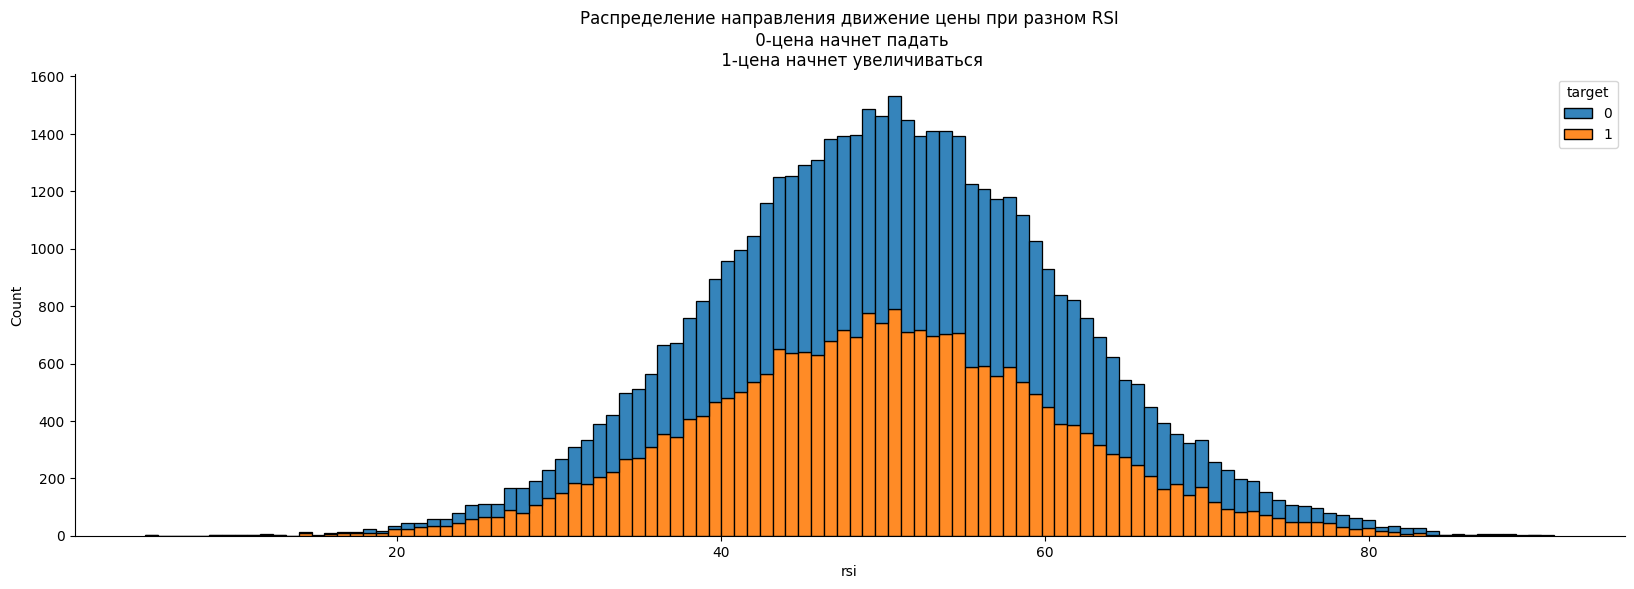

In [103]:
plt.subplots(figsize=(20,6));
sn.histplot(data=sol_data, x='rsi', hue='target', multiple='stack', alpha=0.9);
sn.despine(top=True, right=True)
plt.title('Распределение направления движение цены при разном RSI\n 0-цена начнет падать\n 1-цена начнет увеличиваться');

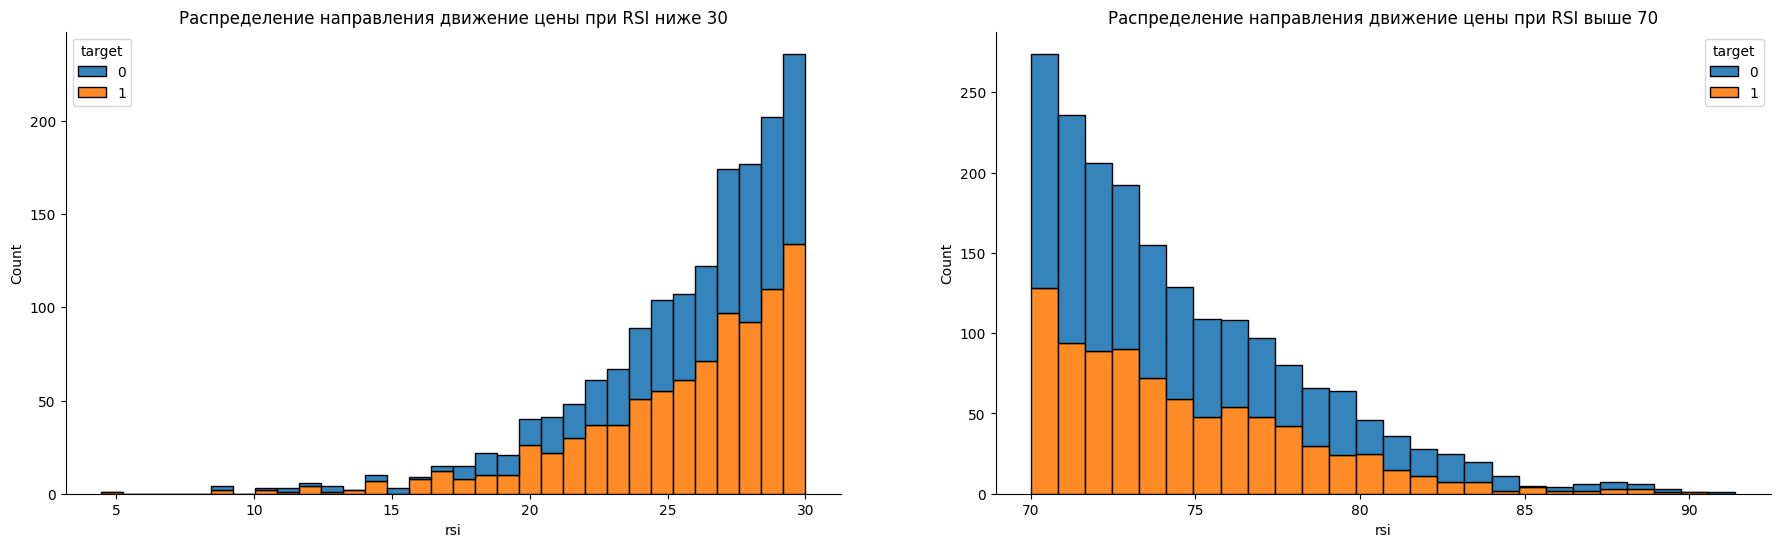

In [104]:
plt.figure(figsize=(22,6))
plt.subplot(121);
sn.histplot(data=sol_data[sol_data['rsi'] < 30], x='rsi', hue='target', multiple='stack', alpha=0.9);
plt.title('Распределение направления движение цены при RSI ниже 30');

plt.subplot(122);
sn.histplot(data=sol_data[sol_data['rsi'] > 70], x='rsi', hue='target', multiple='stack', alpha=0.9);
plt.title('Распределение направления движение цены при RSI выше 70');
sn.despine(top=True, right=True)


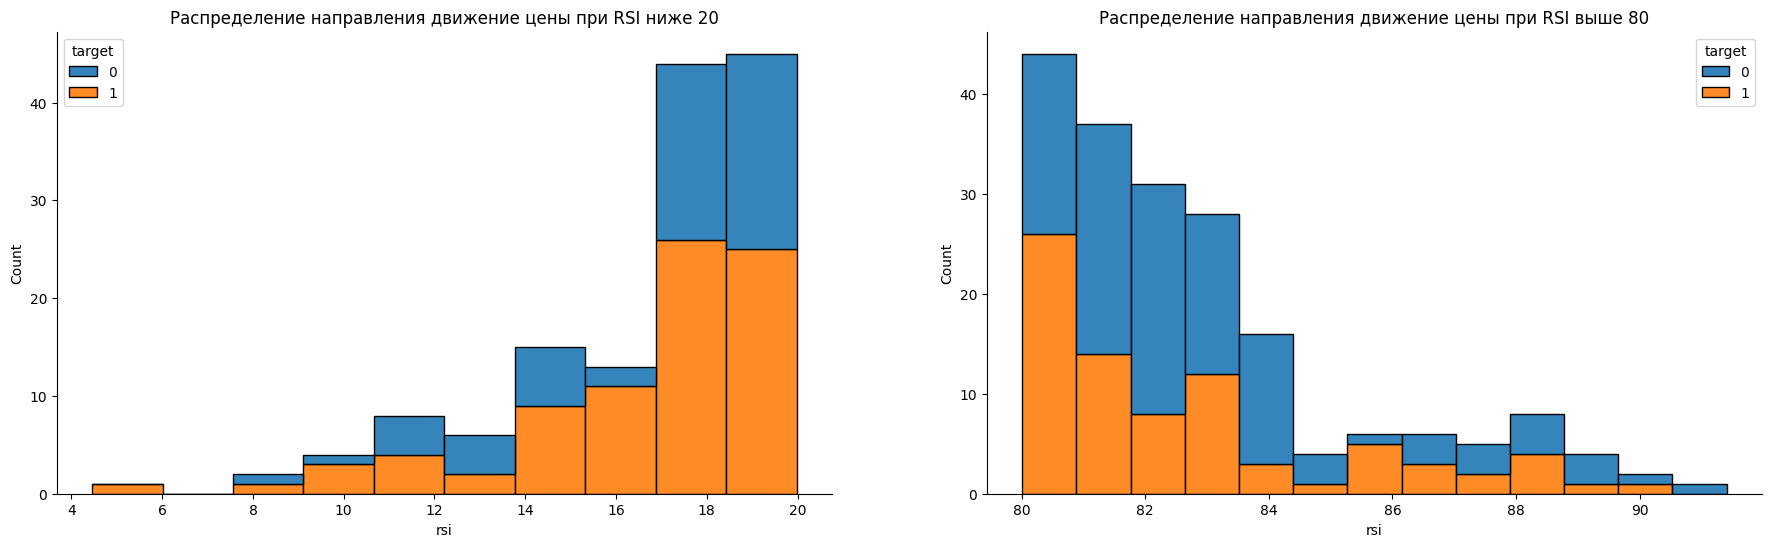

In [105]:
plt.figure(figsize=(22,6))
plt.subplot(121);
sn.histplot(data=sol_data[sol_data['rsi'] < 20], x='rsi', hue='target', multiple='stack', alpha=0.9);
sn.despine(top=True, right=True)
plt.title('Распределение направления движение цены при RSI ниже 20');

plt.subplot(122);
sn.histplot(data=sol_data[sol_data['rsi'] > 80], x='rsi', hue='target', multiple='stack', alpha=0.9);
sn.despine(top=True, right=True)
plt.title('Распределение направления движение цены при RSI выше 80');

**ВЫВОД ПОСЛЕ АНАЛИЗА RSI**

* **Разбор направлений движения цены после достижения каких либо критических значений RSI вообще не гарантирует предсказания направления цены**

### Пересечение линий MACD

**Для того, чтобы добавить признак пересечения линий MACD вверх\вниз и для простоты кода, чтобы не передавать в функцию весь датафрейм, а использовать быстрые стандартные функции, выполним работу в 2 шага. Шифт+эплай**

In [109]:
sol_data['macd_hist_prev'] = sol_data['macd_hist'].shift(1)

In [110]:
def macd_cross(data):
    if data['macd_hist_prev'] < 0 and data['macd_hist'] >= 0:
        return('пересечение вверх')
    if data['macd_hist_prev'] > 0 and data['macd_hist'] <= 0:
        return('пересечение вниз')
    else:
        return('пересечение отсутствует')

In [111]:
sol_data['is_macd_crossing'] = sol_data.apply(lambda row: macd_cross(row), axis=1)

In [112]:
sol_data['is_macd_crossing'].value_counts()

is_macd_crossing
пересечение отсутствует    44808
пересечение вниз            2589
пересечение вверх           2588
Name: count, dtype: int64

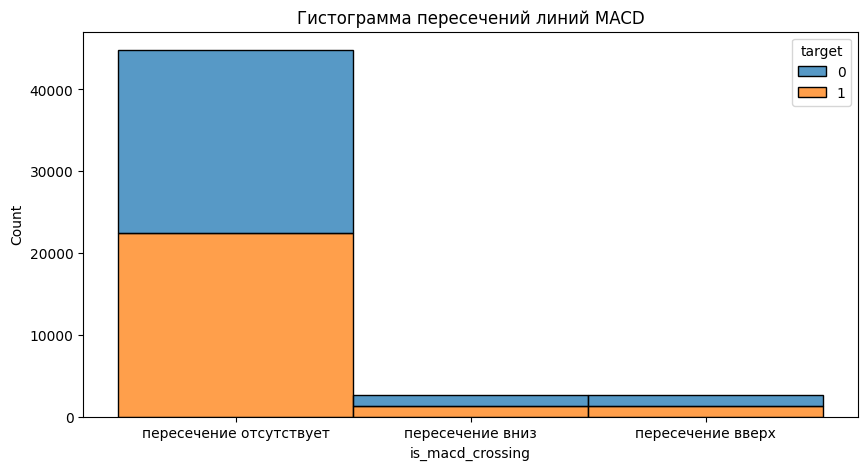

In [113]:
plt.subplots(figsize=(10,5));
sn.histplot(data=sol_data, x='is_macd_crossing', hue='target', multiple='stack');
plt.title('Гистограмма пересечений линий MACD');

**WHAT!? wait a minute**

In [115]:
sol_data[sol_data['is_macd_crossing']=='пересечение вверх']['target'].value_counts()

target
0    1354
1    1234
Name: count, dtype: int64

In [116]:
sol_data[sol_data['is_macd_crossing']=='пересечение вверх']['target'].value_counts(normalize=True)

target
0    0.523184
1    0.476816
Name: proportion, dtype: float64

**Более того в 52% случаев, после пересечения линии MACD вверх, цена падает:)**

**Я в ахуе, популярная страта торговли от пересечений линий MACD просто ни о чем**

In [119]:
sol_data[sol_data['is_macd_crossing']=='пересечение вниз']['target'].value_counts(normalize=True)

target
0    0.509463
1    0.490537
Name: proportion, dtype: float64

**Более того, при пересечении линий MACD и вниз, тоже, цена чаще падает**

**Возможно минутный таймфрейм дает много ложный сигналов**

### Линии стохастика

**Так же добавим признак факта пересечения, хоть он и не основной. Вспомним, что основной наблюдаемый факт стохастика это пересечение медленной или медленной+быстрой (что лучше) уровней 20 и 80, в то время как пересечение линий стохастика аналогично линиям MACD на этих уровнях является дополнительным сигналом**

Для проверки факта пересечения добавим hist

In [125]:
def stoch_hist(row):
    return(row['stoch_k'] - row['stoch_d'])

In [126]:
sol_data['stoch_hist'] = sol_data.apply(lambda row: stoch_hist(row), axis=1)

**Теперь добавим проверку на пересечение**

In [128]:
sol_data['stoch_hist_prev'] = sol_data['stoch_hist'].shift(1)

In [129]:
def stoch_cross(data):
    if data['stoch_hist_prev'] < 0 and data['stoch_hist'] >= 0:
        return('пересечение вверх')
    if data['stoch_hist_prev'] > 0 and data['stoch_hist'] <= 0:
        return('пересечение вниз')
    else:
        return('пересечение отсутствует')

In [130]:
sol_data['is_stoch_crossing'] = sol_data.apply(lambda row: stoch_cross(row), axis=1)

In [131]:
sol_data.sample(5)

,open_price,high_price,low_price,close_price,trade_volume,next_close_price,next_high_price,target,ema_50,ema_100,ema_200,delta_ema_50,delta_ema_100,delta_ema_200,rsi,macd_line,signal_line,macd_hist,stoch_k,stoch_d,rsi_lvl,macd_hist_prev,is_macd_crossing,stoch_hist,stoch_hist_prev,is_stoch_crossing
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-05-16 05:10:00,160.690,161.390,160.570,161.320,18429.7,161.020,161.470,0,159.074196,157.065236,153.943649,2.245804,4.254764,7.376351,64.513302,0.193313,0.219209,-0.025896,85.561497,60.675381,средние значения,-0.110155,пересечение отсутствует,24.886116,7.239057,пересечение отсутствует
2024-02-19 20:40:00,113.294,113.568,113.277,113.552,12306.0,113.322,113.815,0,113.355649,113.137684,112.796048,0.196351,0.414316,0.755952,52.844969,-0.041398,-0.130276,0.088877,78.109798,65.409853,средние значения,0.061721,пересечение отсутствует,12.699945,1.740684,пересечение отсутствует
2024-03-21 03:40:00,192.093,194.800,191.868,193.653,124465.3,195.122,195.691,1,189.105714,185.227033,180.972101,4.547286,8.425967,12.680899,63.702684,0.331779,0.138297,0.193482,78.872721,55.600654,средние значения,-0.053548,пересечение вверх,23.272067,30.662504,пересечение отсутствует
2024-05-14 13:50:00,146.200,146.250,145.850,145.900,6367.8,145.980,146.270,1,146.272013,146.496766,146.538993,-0.372013,-0.596766,-0.638993,46.579262,-0.064518,-0.043569,-0.020949,40.540541,42.342342,средние значения,-0.009124,пересечение отсутствует,-1.801802,13.288288,пересечение вниз
2024-06-20 16:25:00,135.890,135.990,134.710,135.470,115945.6,134.910,135.470,0,137.925238,137.368611,136.856826,-2.455238,-1.898611,-1.386826,22.881892,-0.821227,-0.468236,-0.352990,15.767635,12.341555,перепроданнсть_30,-0.337583,пересечение отсутствует,3.426080,4.612671,пересечение отсутствует


**Для наглядности переставим столбы датафрейма тематически друг за другом**

In [133]:
sol_data.columns

Index(['open_price', 'high_price', 'low_price', 'close_price', 'trade_volume',
       'next_close_price', 'next_high_price', 'target', 'ema_50', 'ema_100',
       'ema_200', 'delta_ema_50', 'delta_ema_100', 'delta_ema_200', 'rsi',
       'macd_line', 'signal_line', 'macd_hist', 'stoch_k', 'stoch_d',
       'rsi_lvl', 'macd_hist_prev', 'is_macd_crossing', 'stoch_hist',
       'stoch_hist_prev', 'is_stoch_crossing'],
      dtype='object')

In [134]:
sol_data = sol_data.reindex(columns=['open_price', 'high_price', 'low_price', 'close_price', 'trade_volume','next_close_price', 'target',
                                     'ema_50', 'ema_100', 'ema_200',
                                     'delta_ema_50', 'delta_ema_100', 'delta_ema_200',
                                     'rsi', 'rsi_lvl',
                                     'macd_line','signal_line', 'macd_hist','macd_hist_prev', 'is_macd_crossing',
                                     'stoch_k', 'stoch_d','stoch_hist', 'stoch_hist_prev','is_stoch_crossing'])

**Добавим еще 2 признака:**

* Факт пересечения **медленной** линии стохастика уровня 80 вниз или уровня 20 вверх
* Факт пересечения **быстрой** линии стохастика уровня 80 вниз или уровня 20 вверх

In [136]:
sol_data['stoch_k_prev'] = sol_data['stoch_k'].shift(1)

In [137]:
sol_data['stoch_d_prev'] = sol_data['stoch_d'].shift(1)

In [138]:
def stoch_lvl(row, char):
    if char == 'k':
        if row['stoch_k_prev'] > 80 and row['stoch_k'] < 80:
            return('падение под 80')
        if row['stoch_k_prev'] < 20 and row['stoch_k'] > 20:
            return('рост выше 20')
        else:
            return('сигнал отсутствует')
    if char == 'd':
        if row['stoch_d_prev'] > 80 and row['stoch_d'] < 80:
            return('падение под 80')
        if row['stoch_d_prev'] < 20 and row['stoch_d'] > 20:
            return('рост выше 20')
        else:
            return('сигнал отсутствует')

In [139]:
sol_data['stoch_k_lvl'] = sol_data.apply(lambda row: stoch_lvl(row,'k'), axis=1)

In [140]:
sol_data['stoch_d_lvl'] = sol_data.apply(lambda row: stoch_lvl(row,'d'), axis=1)

In [141]:
sol_data.head(5)

,open_price,high_price,low_price,close_price,trade_volume,next_close_price,target,ema_50,ema_100,ema_200,delta_ema_50,delta_ema_100,delta_ema_200,rsi,rsi_lvl,macd_line,signal_line,macd_hist,macd_hist_prev,is_macd_crossing,stoch_k,stoch_d,stoch_hist,stoch_hist_prev,is_stoch_crossing,stoch_k_prev,stoch_d_prev,stoch_k_lvl,stoch_d_lvl
date_time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-01-01 16:35:00,105.924,105.941,105.382,105.466,20102.4,105.806,1,104.525660,103.956305,103.248935,0.940340,1.509695,2.217065,57.250350,средние значения,0.261742,0.239885,0.021857,NaN,пересечение отсутствует,59.250474,70.192916,-10.942441,NaN,пересечение отсутствует,NaN,NaN,сигнал отсутствует,сигнал отсутствует
2024-01-01 16:40:00,105.466,105.859,105.350,105.806,10822.2,105.724,0,104.575869,103.992933,103.274378,1.230131,1.813067,2.531622,61.038870,средние значения,0.271645,0.246237,0.025408,0.021857,пересечение отсутствует,75.379507,71.869070,3.510436,-10.942441,пересечение вверх,59.250474,70.192916,сигнал отсутствует,сигнал отсутствует
2024-01-01 16:45:00,105.806,105.833,105.619,105.724,13272.1,105.732,1,104.620894,104.027212,103.298753,1.103106,1.696788,2.425247,59.665524,средние значения,0.262673,0.249524,0.013149,0.025408,пересечение отсутствует,67.247956,67.292646,-0.044689,3.510436,пересечение вниз,75.379507,71.869070,сигнал отсутствует,сигнал отсутствует
2024-01-01 16:50:00,105.724,105.759,105.517,105.732,8156.6,105.445,0,104.664467,104.060970,103.322964,1.067533,1.671030,2.409036,59.760647,средние значения,0.250873,0.249794,0.001079,0.013149,пересечение отсутствует,67.683924,70.103796,-2.419872,-0.044689,пересечение отсутствует,67.247956,67.292646,сигнал отсутствует,сигнал отсутствует
2024-01-01 16:55:00,105.732,105.795,105.445,105.445,11218.1,104.756,0,104.695076,104.088376,103.344079,0.749924,1.356624,2.100921,54.770300,средние значения,0.204632,0.240762,-0.036129,0.001079,пересечение вниз,52.043597,62.325159,-10.281562,-2.419872,пересечение отсутствует,67.683924,70.103796,сигнал отсутствует,сигнал отсутствует


Из-за функции шифт выше, получились пропуски в новых столбцах в 0 строке датафрейма. Удалим ее чтобы не было пропусков.

In [143]:
sol_data = sol_data.drop(sol_data.index[0])

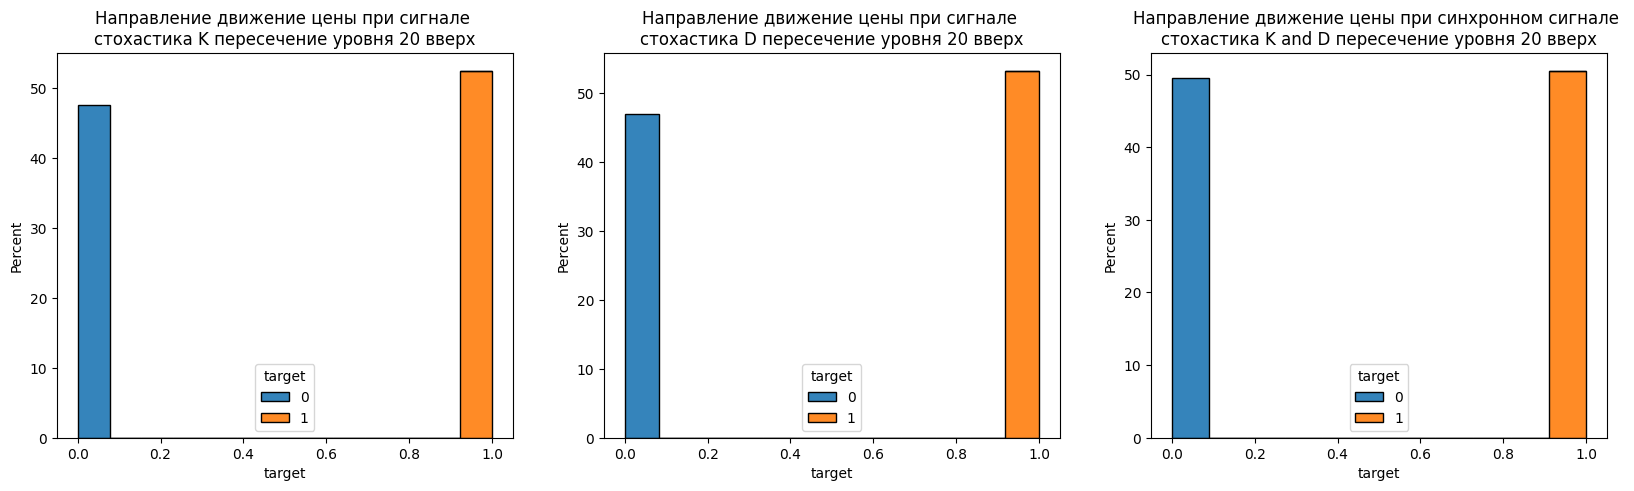

In [144]:
plt.figure(figsize=(20,5));

plt.subplot(131);
sn.histplot(data=sol_data[sol_data['stoch_k_lvl']=='рост выше 20'], x='target', hue='target', multiple='stack', alpha=0.9, stat='percent');
plt.title('Направление движение цены при сигнале \nстохастика K пересечение уровня 20 вверх');

plt.subplot(132);
sn.histplot(data=sol_data[sol_data['stoch_d_lvl']=='рост выше 20'], x='target', hue='target', multiple='stack', alpha=0.9, stat='percent');
plt.title('Направление движение цены при сигнале \nстохастика D пересечение уровня 20 вверх');

plt.subplot(133);
sn.histplot(data=sol_data[(sol_data['stoch_d_lvl']=='рост выше 20') & (sol_data['stoch_k_lvl']=='рост выше 20')], x='target', hue='target', multiple='stack', alpha=0.9, stat='percent');
plt.title('Направление движение цены при синхронном сигнале \nстохастика K and D пересечение уровня 20 вверх');

**Опять сигналы стохастика также не дают никаких определенных сигналов**

In [146]:
sol_data.drop(['open_price','high_price','low_price','close_price','trade_volume','ema_50','ema_100','ema_200','delta_ema_50','delta_ema_100','delta_ema_200'],axis=1).tail(14)

,next_close_price,target,rsi,rsi_lvl,macd_line,signal_line,macd_hist,macd_hist_prev,is_macd_crossing,stoch_k,stoch_d,stoch_hist,stoch_hist_prev,is_stoch_crossing,stoch_k_prev,stoch_d_prev,stoch_k_lvl,stoch_d_lvl
date_time,,,,,,,,,,,,,,,,,,
2024-07-22 03:15:00,183.54,0,49.880547,средние значения,0.048805,0.149939,-0.101134,-0.066095,пересечение отсутствует,14.084507,23.768910,-9.684403,-10.185185,пересечение отсутствует,27.777778,37.962963,сигнал отсутствует,сигнал отсутствует
2024-07-22 03:20:00,183.79,1,46.953770,средние значения,-0.017438,0.116463,-0.133902,-0.101134,пересечение отсутствует,12.269939,18.044074,-5.774136,-9.684403,пересечение отсутствует,14.084507,23.768910,сигнал отсутствует,сигнал отсутствует
2024-07-22 03:25:00,184.13,1,50.665009,средние значения,-0.035028,0.086165,-0.121193,-0.133902,пересечение отсутствует,27.607362,17.987269,9.620093,-5.774136,пересечение вверх,12.269939,18.044074,рост выше 20,сигнал отсутствует
2024-07-22 03:30:00,183.69,0,55.250406,средние значения,-0.008545,0.067223,-0.075768,-0.121193,пересечение отсутствует,48.466258,29.447853,19.018405,9.620093,пересечение отсутствует,27.607362,17.987269,сигнал отсутствует,рост выше 20
2024-07-22 03:35:00,183.60,0,48.914380,средние значения,-0.038915,0.045995,-0.084910,-0.075768,пересечение отсутствует,21.472393,32.515337,-11.042945,19.018405,пересечение вниз,48.466258,29.447853,сигнал отсутствует,сигнал отсутствует
2024-07-22 03:40:00,183.57,0,47.709183,средние значения,-0.068950,0.023006,-0.091956,-0.084910,пересечение отсутствует,15.950920,28.629857,-12.678937,-11.042945,пересечение отсутствует,21.472393,32.515337,сигнал отсутствует,сигнал отсутствует
2024-07-22 03:45:00,183.35,0,47.290908,средние значения,-0.091346,0.000136,-0.091482,-0.091956,пересечение отсутствует,14.110429,17.177914,-3.067485,-12.678937,пересечение отсутствует,15.950920,28.629857,сигнал отсутствует,сигнал отсутствует
2024-07-22 03:50:00,182.98,0,44.228593,средние значения,-0.129018,-0.025695,-0.103323,-0.091482,пересечение отсутствует,1.219512,10.426954,-9.207442,-3.067485,пересечение отсутствует,14.110429,17.177914,сигнал отсутствует,сигнал отсутствует
2024-07-22 03:55:00,182.67,0,39.585839,средние значения,-0.192989,-0.059154,-0.133835,-0.103323,пересечение отсутствует,10.762332,8.697424,2.064907,-9.207442,пересечение вверх,1.219512,10.426954,сигнал отсутствует,сигнал отсутствует


In [147]:
sol_data.to_csv('H:\sol_data.csv', index=True)

**------------------------------------------**

**------------------------------------------**

## Подготовка данных для ML

**Изучим корреляцию**

In [177]:
phik_col = sol_data.drop(['open_price','high_price','low_price','close_price','trade_volume', 'next_close_price'], axis=1)

In [179]:
phik_col_interval = phik_col.select_dtypes(include=['number']).columns

In [181]:
phik_col_interval

Index(['target', 'ema_50', 'ema_100', 'ema_200', 'delta_ema_50',
       'delta_ema_100', 'delta_ema_200', 'rsi', 'macd_line', 'signal_line',
       'macd_hist', 'macd_hist_prev', 'stoch_k', 'stoch_d', 'stoch_hist',
       'stoch_hist_prev', 'stoch_k_prev', 'stoch_d_prev'],
      dtype='object')

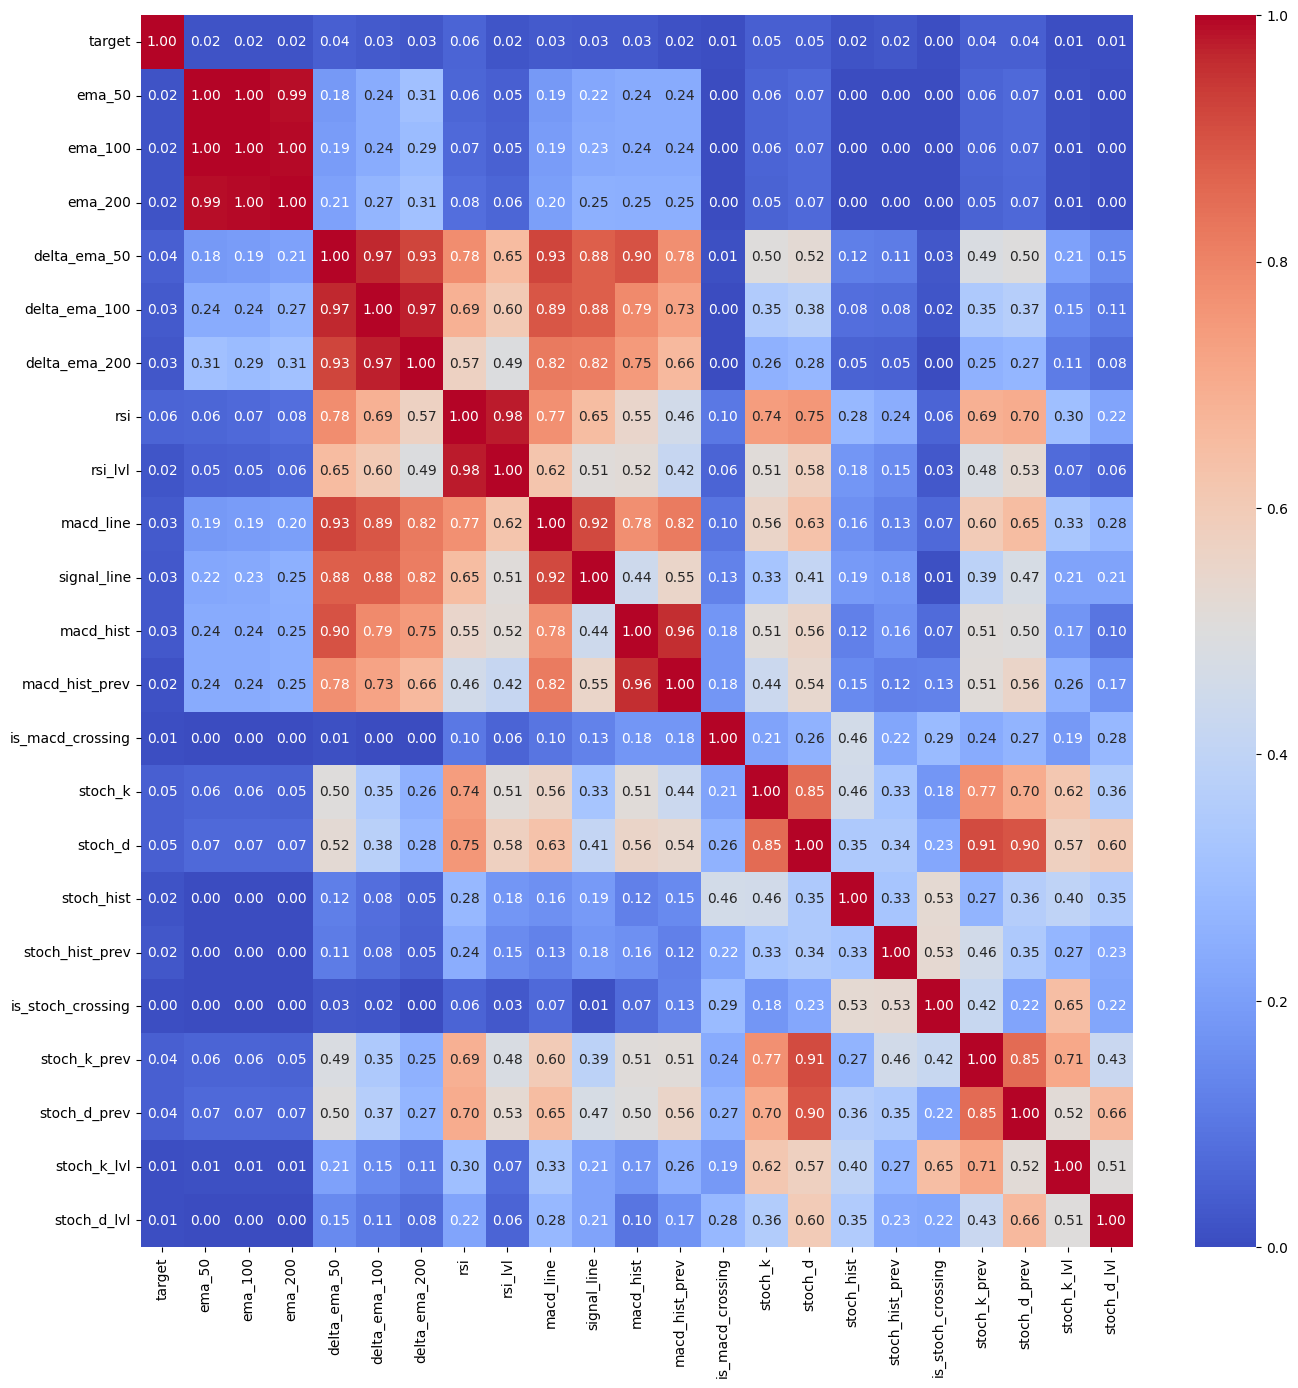

In [183]:
plt.subplots(figsize=(16, 16));
sn.heatmap(phik_col.phik_matrix(interval_cols=phik_col_interval),
           annot=True,
           annot_kws={"size": 10},
           fmt='.2f',
           cmap='coolwarm');

**Наблюдаем высочайшую (что не удивительно) мультиколинеарность между всеми признаками вида ema_ и delta_ema_, для обучения моделей уберем их из обучающего датасета**


**Спойлер:** обучение проводилось и с полным сетом и с очищенным от мультиколинеарности, логическая регерессия чуть-чуть подтянулась, а бустовые модели показали теже результаты

In [ ]:
sol_data.isna().sum()

В датасете появились пропуски связанные с тем, что для некоторых столбоцов перед появлением в них первой информации, требовался сбор с N-го количества предшествующих строк. Для того чтобы в данных не было пропусков, мы просто удалим первые 200 строк, что уберет все пропуски, и не потребуется заполнять их недействительными данными.

In [ ]:
sol_data = sol_data.drop(sol_data.index[:200])

In [ ]:
sol_data.isna().sum()

### Выбор признаков участвующих в модели

In [ ]:
sol_data.columns

In [ ]:
model_columns = ['target','rsi','signal_line', 'macd_hist', 'stoch_rsi_k', 'stoch_rsi_d','macd_line']

In [ ]:
plt.subplots(figsize=(6, 6));
sn.heatmap(sol_data[model_columns].drop('target', axis=1).phik_matrix(interval_cols=sol_data[model_columns].drop('target', axis=1)),
           annot=True,
           annot_kws={"size": 13},
           fmt='.2f',
           cmap='coolwarm');

In [ ]:
train, test = train_test_split(sol_data[model_columns], shuffle=False, test_size=0.1)

In [ ]:
X_train = train.drop('target', axis=1)

In [ ]:
y_train = train['target']

In [ ]:
X_test = test.drop('target', axis=1)

In [ ]:
y_test = test['target']

In [ ]:
tscv = TimeSeriesSplit(n_splits=2)

In [ ]:
*stop

## Обучение моделей

### LogisticRegression

In [ ]:
num_columns = X_train.select_dtypes(include=['number']).columns

In [ ]:
ohe_columns = X_train.select_dtypes(exclude=['number']).columns

In [ ]:
num_columns

In [ ]:
ohe_columns

In [ ]:
ohe_pipe = Pipeline(
    [
        (
            'ohe', OneHotEncoder(handle_unknown='ignore', drop='first')
        )
    ]
)

In [ ]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [ ]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', None)
    ]
) 

In [ ]:
param_grid = [
    {
        'models': [LogisticRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [ ]:
lr_gs = GridSearchCV(
    pipe_final, 
    param_grid,
    cv=tscv,
    scoring = 'accuracy',
    n_jobs=-1,
    verbose=2
)

In [ ]:
lr_gs.fit(X_train, y_train)

In [ ]:
lr_score = lr_gs.best_score_

In [ ]:
print ('Метрика лучшей модели на кроссвалидации:', lr_score)

In [ ]:
lr_prediction = lr_gs.best_estimator_.predict(X_test)

In [ ]:
lr_accuracy = accuracy_score(y_test, lr_prediction)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr_gs.best_estimator_, X_test, y_test);

In [ ]:
print("Accuracy Score:", lr_accuracy)

### Catboost

In [ ]:
model = CatBoostClassifier(max_depth=4, random_state=RANDOM_STATE, verbose=False)

In [ ]:
param_grid_cat = [

    {
        'learning_rate':[0.1, 0.3]
    }
]

In [ ]:
catboost_gs = GridSearchCV(
    model, 
    param_grid_cat,
    cv=tscv,
    scoring = 'accuracy',  
    n_jobs=-1,
    verbose=2
)

In [ ]:
catboost_gs.fit(X_train, y_train)

In [ ]:
catboost_score = round((catboost_gs.best_score_), 4)

In [ ]:
print(f'Метрика на кросс-валидационной выборке: {catboost_score}')

In [ ]:
catboost_prediction = catboost_gs.best_estimator_.predict(X_test)

In [ ]:
catboost_accuracy = accuracy_score(y_test, catboost_prediction)

In [ ]:
print("Accuracy Score:", catboost_accuracy)

In [ ]:
ConfusionMatrixDisplay.from_estimator(catboost_gs.best_estimator_, X_test, y_test);

### LGB

In [ ]:
model_lgb = lgb.LGBMClassifier(random_state=RANDOM_STATE,  force_col_wise=True)

In [ ]:
param_grid_gbm = {
 'learning_rate': [0.1, 0.05],
 'n_estimators': [150 ,100],
 'max_depth': [5,7],
 'num_leaves':[3,5,7]
}

In [ ]:
lgbm_gs = GridSearchCV(model_lgb, param_grid_gbm, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

In [ ]:
lgbm_gs.fit(X_train, y_train)

In [ ]:
lgbm_score = round((lgbm_gs.best_score_),4)

In [ ]:
print(f'Метрика accuracy_score для лучшей модели c градиентным бустингом на кроссвалидации равна {lgbm_score}')

In [ ]:
lgbm_prediction = lgbm_gs.best_estimator_.predict(X_test)

In [ ]:
lgbm_accuracy = accuracy_score(y_test, lgbm_prediction)

In [ ]:
print("Accuracy Score:", lgbm_accuracy)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs.best_estimator_, X_test, y_test);

## Оценка и анализ результатов моделей

### Суммирование оценок моделей

In [ ]:
cross_val_scores = lr_score, catboost_score, lgbm_score
test_scores = lr_accuracy, catboost_accuracy, lgbm_accuracy

In [ ]:
models = ['Logistic_regression','Catboost','LGBM']

In [ ]:
results_df = pd.DataFrame({
    'Models': models,
    'Cross_val_score': cross_val_scores,
    'Test_score': test_scores
                          })

In [ ]:
results_df = results_df.sort_values('Cross_val_score', ascending=False)

In [ ]:
results_df = results_df.set_index('Models')

In [ ]:
results_df

#### Матрицы ошибок

In [ ]:
ConfusionMatrixDisplay.from_estimator(lr_gs.best_estimator_, X_test, y_test);

In [ ]:
ConfusionMatrixDisplay.from_estimator(catboost_gs.best_estimator_, X_test, y_test);

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs.best_estimator_, X_test, y_test);

## Анализ важности признаков моделей

### Логистическая регрессия

In [ ]:
lr_shap = lr_gs.best_estimator_.named_steps['preprocessor'].transform(X_test)

In [ ]:
explainer = shap.LinearExplainer(lr_gs.best_estimator_['models'], lr_shap)

In [ ]:
num_names = lr_gs.best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out()

In [ ]:
explainer.feature_names = num_names

In [ ]:
shap_values = explainer(lr_shap)

In [ ]:
plt.subplots(figsize=(12, 6))
plt.title(label='График значимости признаков' , fontsize=15)
plt.xlabel('shap_value или значимость', fontsize=15)
plt.ylabel('Имя признака', fontsize=15)
shap.plots.bar(shap_values, max_display=20)
plt.show()

### Анализ важности признаков catboost

In [ ]:
importances = catboost_gs.best_estimator_.get_feature_importance()

In [ ]:
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})

In [ ]:
importances_df = importances_df.sort_values('Importance', ascending=False)

In [ ]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df, palette='Blues_d')
plt.title('Важность признаков CatBoost')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

### Анализ важности признаков LGBM

In [ ]:
importances_lgbm = lgbm_gs.best_estimator_.feature_importances_

In [ ]:
importances_df_lgbm = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances_lgbm})

In [ ]:
importances_df_lgbm = importances_df_lgbm.sort_values('Importance', ascending=False)

In [ ]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df_lgbm, palette='Blues_d')
plt.title('Важность признаков LGBM')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

In [ ]:
explainer_lgbm = shap.Explainer(lgbm_gs.best_estimator_)

In [ ]:
shap_values = explainer_lgbm(X_train)

In [ ]:
shap.summary_plot(shap_values, X_train)

## Настройка лучшей модели

Кроссвалидация и метрика тоночсти показала небольшое, но преимущество LGBM модели над остальными

Что более важно, матрица ошибок LGBM модели показала, что у LGBM модели самая высокая **специфичность**, т.е она заметно лучше остальных моделей предсказывает **падение цены**

**Отталкиваясь от данного факта, попробуем улучшить эту модель**

In [ ]:
sol_data.columns

### Попытка обучения LGBM №2

In [ ]:
model_lgbm_columns = ['target', 'ema_50', 'ema_100', 'ema_200', 'rsi', 'macd_line',
       'signal_line', 'macd_hist', 'stoch_rsi_k', 'stoch_rsi_d',
       'delta_ema_50', 'delta_ema_100', 'delta_ema_200']

In [ ]:
train_lgbm, test_lgbm = train_test_split(sol_data[model_lgbm_columns], shuffle=False, test_size=0.1)

In [ ]:
X_train_lgbm = train_lgbm.drop('target', axis=1)

In [ ]:
y_train_lgbm = train_lgbm['target']

In [ ]:
X_test_lgbm = test_lgbm.drop('target', axis=1)

In [ ]:
y_test_lgbm = test_lgbm['target']

In [ ]:
model_lgbm_2 = lgb.LGBMClassifier(random_state=RANDOM_STATE,  force_col_wise=True)

In [ ]:
param_grid_gbm = {
 'learning_rate': [0.01],
 'n_estimators': [250, 500, 1000],
 'max_depth': range(2,10),
 'num_leaves': range(2,10)
}

In [ ]:
lgbm_gs_2 = GridSearchCV(model_lgbm_2, param_grid_gbm, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

In [ ]:
lgbm_gs_2.fit(X_train_lgbm, y_train_lgbm)

In [ ]:
lgbm_score_2 = round((lgbm_gs_2.best_score_),4)

In [ ]:
print(f'Метрика accuracy_score на кроссвалидации для модели LGBM_2 равна {lgbm_score_2}')

In [ ]:
lgbm_prediction_2 = lgbm_gs_2.best_estimator_.predict(X_test_lgbm)

In [ ]:
lgbm_accuracy_2 = accuracy_score(y_test_lgbm, lgbm_prediction_2)

In [ ]:
print("Accuracy Score:", lgbm_accuracy_2)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs_2.best_estimator_, X_test_lgbm, y_test_lgbm);

In [ ]:
importances_lgbm_2 = lgbm_gs_2.best_estimator_.feature_importances_

In [ ]:
importances_df_lgbm_2 = pd.DataFrame({'Feature': X_train_lgbm.columns, 'Importance': importances_lgbm_2})

In [ ]:
importances_df_lgbm_2 = importances_df_lgbm_2.sort_values('Importance', ascending=False)

In [ ]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df_lgbm_2, palette='Blues_d')
plt.title('Важность признаков LGBM')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

### Попытка обучения №3

In [ ]:
m_col_3 = ['target',  'rsi', 'macd_line',
       'signal_line', 'macd_hist', 'stoch_rsi_k', 'stoch_rsi_d',
       'delta_ema_50', 'delta_ema_100', 'delta_ema_200']

In [ ]:
train_lgbm_3, test_lgbm_3 = train_test_split(sol_data[m_col_3], shuffle=False, test_size=0.1)

In [ ]:
X_train_lgbm_3 = train_lgbm_3.drop('target', axis=1)

In [ ]:
y_train_lgbm_3 = train_lgbm_3['target']

In [ ]:
X_test_lgbm_3 = test_lgbm_3.drop('target', axis=1)

In [ ]:
y_test_lgbm_3 = test_lgbm_3['target']

In [ ]:
model_lgbm_3 = lgb.LGBMClassifier(random_state=RANDOM_STATE,  force_col_wise=True)

In [ ]:
param_grid_gbm = {
 'learning_rate': [0.01],
 'n_estimators': [250, 500, 1000],
 'max_depth': range(2,10),
 'num_leaves': range(2,10)
}

In [ ]:
lgbm_gs_3 = GridSearchCV(model_lgbm_3, param_grid_gbm, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

In [ ]:
lgbm_gs_3.fit(X_train_lgbm_3, y_train_lgbm_3)

In [ ]:
lgbm_score_3 = round((lgbm_gs_3.best_score_),4)

In [ ]:
print(f'Метрика accuracy_score на кроссвалидации для модели LGBM_3 равна {lgbm_score_3}')

In [ ]:
lgbm_prediction_3 = lgbm_gs_3.best_estimator_.predict(X_test_lgbm_3)

In [ ]:
lgbm_accuracy_3 = accuracy_score(y_test_lgbm_3, lgbm_prediction_3)

In [ ]:
print("Accuracy Score:", lgbm_accuracy_3)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs_3.best_estimator_, X_test_lgbm_3, y_test_lgbm_3);

In [ ]:
importances_lgbm_3 = lgbm_gs_3.best_estimator_.feature_importances_
importances_df_lgbm_3 = pd.DataFrame({'Feature': X_train_lgbm_3.columns, 'Importance': importances_lgbm_3})
importances_df_lgbm_3 = importances_df_lgbm_3.sort_values('Importance', ascending=False)

In [ ]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df_lgbm_3, palette='Blues_d')
plt.title('Важность признаков LGBM')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

### Попытка обучения №4

In [ ]:
m_col_4 = ['target',  'rsi',
       'signal_line', 'macd_hist', 'stoch_rsi_k', 'stoch_rsi_d',
       'delta_ema_50', 'delta_ema_100', 'delta_ema_200']

In [ ]:
train_lgbm, test_lgbm = train_test_split(sol_data[m_col_4], shuffle=False, test_size=0.1)

In [ ]:
X_train_lgbm_4 = train_lgbm.drop('target', axis=1)

In [ ]:
y_train_lgbm_4 = train_lgbm['target']

In [ ]:
X_test_lgbm_4 = test_lgbm.drop('target', axis=1)

In [ ]:
y_test_lgbm_4 = test_lgbm['target']

In [ ]:
model_lgbm_4 = lgb.LGBMClassifier(random_state=RANDOM_STATE,  force_col_wise=True)

In [ ]:
param_grid_gbm = {
 'learning_rate': [0.01],
 'n_estimators': [250, 500, 1000],
 'max_depth': range(2,10),
 'num_leaves': range(2,10)
}

In [ ]:
lgbm_gs_4 = GridSearchCV(model_lgbm_4, param_grid_gbm, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

In [ ]:
lgbm_gs_4.fit(X_train_lgbm_4, y_train_lgbm_4)

In [ ]:
lgbm_score_4 = round((lgbm_gs_4.best_score_),4)

In [ ]:
print(f'Метрика accuracy_score на кроссвалидации для модели LGBM_4 равна {lgbm_score_4}')

In [ ]:
lgbm_prediction_4 = lgbm_gs_4.best_estimator_.predict(X_test_lgbm_4)
lgbm_accuracy_4 = accuracy_score(y_test_lgbm_4, lgbm_prediction_4)
print("Accuracy Score:", lgbm_accuracy_4)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs_4.best_estimator_, X_test_lgbm_4, y_test_lgbm_4);

In [ ]:
importances_lgbm_4 = lgbm_gs_4.best_estimator_.feature_importances_
importances_df_lgbm_4 = pd.DataFrame({'Feature': X_train_lgbm_4.columns, 'Importance': importances_lgbm_4})
importances_df_lgbm_4 = importances_df_lgbm_4.sort_values('Importance', ascending=False)

In [ ]:
plt.figure(figsize=(10, 8))
sn.barplot(x='Importance', y='Feature', data=importances_df_lgbm_4, palette='Blues_d')
plt.title('Важность признаков LGBM')
plt.xlabel('Важность')
plt.ylabel('Признаки')
plt.show()

### Попытка обучения №5

In [ ]:
m_col_5 = ['target',  'rsi', 'macd_hist', 'stoch_rsi_k', 'stoch_rsi_d',
       'delta_ema_50', 'delta_ema_100', 'delta_ema_200']

In [ ]:
train_lgbm, test_lgbm = train_test_split(sol_data[m_col_5], shuffle=False, test_size=0.1)
X_train_lgbm = train_lgbm.drop('target', axis=1)
y_train_lgbm = train_lgbm['target']
X_test_lgbm = test_lgbm.drop('target', axis=1)
y_test_lgbm = test_lgbm['target']

In [ ]:
model_lgbm_5 = lgb.LGBMClassifier(random_state=RANDOM_STATE,  force_col_wise=True)

In [ ]:
param_grid_gbm = {
 'learning_rate': [0.01],
 'n_estimators': [250, 500, 1000],
 'max_depth': range(2,10),
 'num_leaves': range(2,10)
}

In [ ]:
lgbm_gs_5 = GridSearchCV(model_lgbm_5, param_grid_gbm, cv=tscv, scoring='accuracy', n_jobs=-1, verbose=2)

In [ ]:
lgbm_gs_5.fit(X_train_lgbm, y_train_lgbm)

In [ ]:
lgbm_score_5 = round((lgbm_gs_5.best_score_),4)
print(f'Метрика accuracy_score на кроссвалидации для модели LGBM_5 равна {lgbm_score_5}')

In [ ]:
lgbm_prediction_5 = lgbm_gs_5.best_estimator_.predict(X_test_lgbm)
lgbm_accuracy_5 = accuracy_score(y_test_lgbm, lgbm_prediction_5)
print("Accuracy Score:", lgbm_accuracy_5)

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgbm_gs_5.best_estimator_, X_test_lgbm, y_test_lgbm);

### Промежуточный итог 5 моделей LGBM

In [ ]:
cross_val_scores = lgbm_score, lgbm_score_2, lgbm_score_3, lgbm_score_4, lgbm_score_5
test_scores = lgbm_accuracy, lgbm_accuracy_2, lgbm_accuracy_3, lgbm_accuracy_4, lgbm_accuracy_5

In [ ]:
models = ['LGBM','LGBM_2','LGBM_3','LGBM_4','LGBM_5']

In [ ]:
results_lgbm = pd.DataFrame({
    'Models': models,
    'Cross_val_score': cross_val_scores,
    'Test_score': test_scores
                          })

In [ ]:
results_lgbm = results_lgbm.sort_values('Cross_val_score', ascending=False)

In [ ]:
results_lgbm = results_lgbm.set_index('Models')

In [ ]:
results_lgbm